In [4]:
import sklearn
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784',version= 1 )
mnist.keys()
#手写数据集

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

In [5]:
x , y = mnist["data"] ,mnist["target"]
x.shape
type(x)

pandas.core.frame.DataFrame

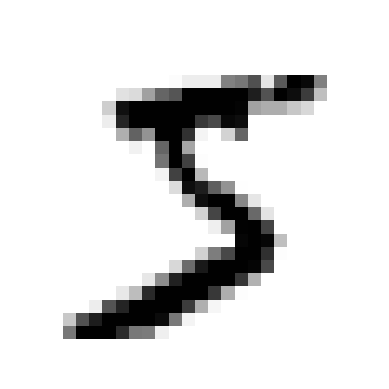

In [6]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

some_digit = x[:1]
#返回的是dataframe格式的数据，不能直接取行，要用loc[]，返回一个dataframe.series数据
#或者使用[:]方式确定一个区间
some_digit_image = some_digit.values.reshape(28,28)
#reshape 已经不支持此版本的series数据类型，需要添加values使用
#print ( some_digit_image)

plt.imshow(some_digit_image ,cmap = "binary")
plt.axis("off")
plt.show()

In [7]:
y = y.astype(np.uint8)
#数据集中的y是文字，将y转化为一个数字变量

In [8]:
x_train , x_test , y_train , y_test = x[:60000] ,x[60000:] , y[:60000], y[60000:]
#分割数据集，训练集60000个数据
y_train_5   = (y_train  == 5)
y_test_5    = (y_test   == 5)
#用布尔型变量作为标志位，判断y是否为5 如果y为5则标志位为True 否则是Flase

In [9]:
#二元分类器
from sklearn.linear_model import SGDClassifier

randomseed = 42
sgd_clf  = SGDClassifier(random_state= randomseed)
sgd_clf.fit(x_train , y_train_5)

SGDClassifier(random_state=42)

In [10]:
sgd_clf.predict(some_digit)
#验证能否检测出手写数据5
#预期结果：返回true

array([ True])

In [11]:
#交叉验证模型效果
from sklearn.model_selection import cross_val_score
#导入交叉验证
cross_val_score (sgd_clf , x_train , y_train_5 , cv= 3 , scoring= "accuracy")
#数据量较大，交叉检验3次即可
#测量的是总准确率


array([0.95035, 0.96035, 0.9604 ])

常规的准确率是将正样本和负样本综合在一起判断的
如果占比较少的一种样本准确率低，总准确率依旧会很高
总准确率并不能代表分类器的性能强弱

In [12]:
#交叉预测
from sklearn.model_selection import cross_val_predict
#导入交叉预测
y_trained_predict = cross_val_predict(sgd_clf , x_train , y_train_5 , cv=3)
#预测3次

In [13]:
#混淆矩阵
from sklearn.metrics import confusion_matrix
#导入混淆矩阵
confusion_matrix(y_train_5 , y_trained_predict)
#利用混淆矩阵判断分类器性能

array([[53892,   687],
       [ 1891,  3530]])

使用混淆矩阵之前，必须要进行预测，得到模型的预测结果，然后再将预测结果与实际结果对照
混淆矩阵结果
TN FP       负样本正确 正样本错误
FN TP       负样本错误 正样本正确

In [14]:
#精确度和召回率
from sklearn.metrics import precision_score ,recall_score
prescore    =   precision_score (y_train_5 , y_trained_predict)
recscore    =   recall_score    (y_train_5 , y_trained_predict)

print("precision score: ",prescore)
print("recall score:    ",recscore)

precision score:  0.8370879772350012
recall score:     0.6511713705958311


precision score = TP/(TP+FP)
recall score    = TP/(TP+FN)

In [15]:
#计算F1分数
from sklearn.metrics import f1_score
#导入f1分数
f1_score(y_train_5 , y_trained_predict)


0.7325171197343846

f1分数只有在精确度和召回率都很高的时候才会高
因此f1分数越高的模型，其性能指标越好
f1分数的缺点是在准确率和召回率相差较大的时候不能有效表示模型效果
f1 = 2*(精确度 × 召回率)/（精确度 + 召回率）

In [16]:
#用阈值更改预测结果
y_scores = sgd_clf.decision_function(some_digit)
y_scores
#用特定元素作为阈值
y_some_digit_predict = ( y_scores >2000)
y_some_digit_predict

array([ True])

In [17]:
#计算所有阈值和召回率
y_scores = cross_val_predict(sgd_clf , x_train , y_train_5 , cv= 5 , method = "decision_function")
#decision_function可以计算出所有可能的阈值和召回率


In [18]:
from sklearn.metrics import precision_recall_curve
#导入预测召回曲线
precisions , recalls , thresholds = precision_recall_curve(y_train_5 , y_scores)
#输入   数据对照集 评分标准
#输出   准确度  召回率  阈值


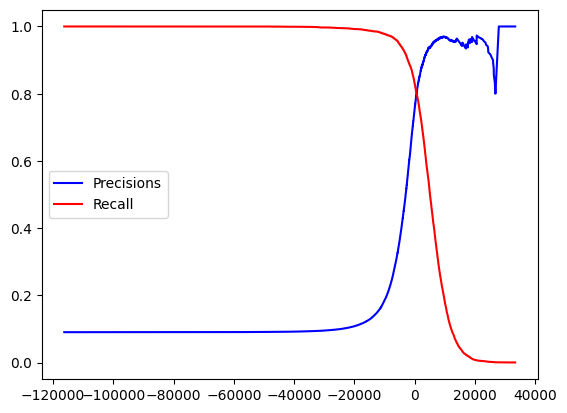

In [19]:
#绘制预测 召回率曲线
def plot_precisions_recalls_vs_thresholds(precisions , recalls , thresholds):
    plt.plot(thresholds , precisions[:-1],'b' , label = "Precisions")
    plt.plot(thresholds , recalls[:-1]   ,'r' , label = "Recall")
    #thresholds比precisions和recalls少一位，需要对齐才能绘图
    #[:-1]是选择从0到最后一位的前一位
    plt.legend()
    plt.show()

plot_precisions_recalls_vs_thresholds(precisions , recalls , thresholds )  

In [20]:
thresholds_90percent = thresholds[np.argmax(precisions >= 0.9)]
#寻找第一个准确率高于90%的阈值
y_train_90percent = (y_scores >= thresholds_90percent)
#根据权重更新判定结果
print(y_train_90percent)

[ True False False ...  True False False]


In [21]:
precision_score(y_train_5 , y_train_90percent)
recall_score(y_train_5 , y_train_90percent)
#测定准确率和召回率
f1_score(y_train_5 , y_train_90percent)

0.760890403663862

In [22]:
from sklearn.metrics import roc_curve
#导入roc曲线
fpr , tpr ,thresholds = roc_curve(y_train_5 , y_scores)

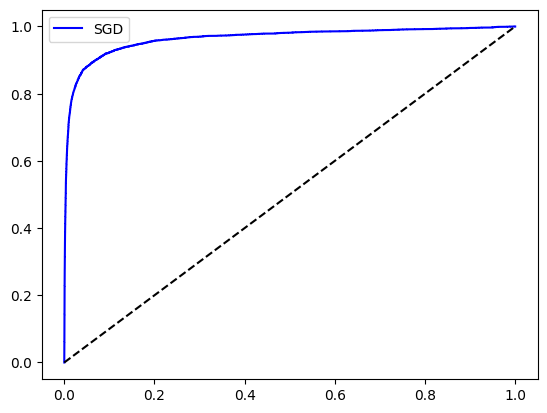

In [23]:
def plot_roc_curve(fpr ,tpr, label ,color = 'b'):#绘制roc曲线图像
    plt.plot(fpr , tpr ,c= color , label= label)#绘制曲线
    plt.plot([0,1],[0,1],'k--')#绘制对角虚线
    plt.legend()

plot_roc_curve(fpr ,tpr , "SGD")

In [24]:
#通过ROC曲线评估模型性能
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5 , y_scores)
#计算roc面积

0.9648211175804801

In [25]:
#利用随机森林算法 演示整个流程

from sklearn.ensemble import RandomForestClassifier

forest_clf  = RandomForestClassifier( random_state= randomseed)

y_proba_forest    = cross_val_predict (forest_clf , x_train , y_train_5 , cv=3 , method = "predict_proba")
#将数据集导入模型
#proba方法返回的是个二位数组

In [26]:
y_scores_forests = y_proba_forest[:,1]

fpr_forest , tpr_forest , thresholds_forest = roc_curve(y_train_5 , y_scores_forests)

In [27]:
print(y_proba_forest)
print(y_scores)
print(y_train_5)

[[0.11 0.89]
 [0.99 0.01]
 [0.96 0.04]
 ...
 [0.02 0.98]
 [0.92 0.08]
 [0.94 0.06]]
[  4411.53413566 -14087.12193543 -21565.51993633 ...   9394.4695853
  -2918.25117218  -9160.6081938 ]
0         True
1        False
2        False
3        False
4        False
         ...  
59995    False
59996    False
59997     True
59998    False
59999    False
Name: class, Length: 60000, dtype: bool


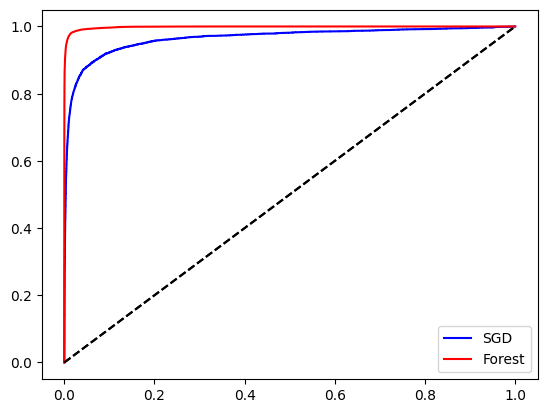

In [28]:
plot_roc_curve(fpr ,tpr, "SGD" )
plot_roc_curve(fpr_forest ,tpr_forest ,"Forest" , 'r' )

In [29]:
#多分类器模型

from sklearn.svm import SVC
#使用支持向量机模型

svm_clf = SVC()
svm_clf.fit(x_train , y_train)

SVC()

In [30]:
svm_clf.predict(some_digit)
#分类第一个数据
#正常的输出结果为5

array([5], dtype=uint8)

In [31]:
some_digit_scores = svm_clf.decision_function(some_digit)
#获得测试样本在各个分类的评分
some_digit_scores

array([[ 1.72501977,  2.72809088,  7.2510018 ,  8.3076379 , -0.31087254,
         9.3132482 ,  1.70975103,  2.76765202,  6.23049537,  4.84771048]])

In [32]:
np.argmax(some_digit_scores)
#获取评分最高的类别号

5

In [33]:
svm_clf.classes_
#获取类别信息

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [34]:
svm_clf.classes_[np.argmax(some_digit_scores)]
#相当于上方的predict()函数


5

In [35]:
#使用一对剩余策略
from sklearn.multiclass import OneVsOneClassifier

ovc_clf = OneVsOneClassifier(SVC())
ovc_clf.fit(x_train , y_train)


OneVsOneClassifier(estimator=SVC())

In [36]:
ovc_clf.predict(some_digit)

array([5], dtype=uint8)

In [37]:
"""
#使用标准化提高准确率
from sklearn.preprocessing import StandardScaler
#导入标准化
score_nonestandard  = cross_val_score(sgd_clf , x_train , y_train ,cv = 3 ,scoring = "accuracy")
print("nonestandard accuracy :  " , score_nonestandard)

scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train)
#归一化，均值为0 ，方差为1
score_standard      = cross_val_score(sgd_clf , x_train_scaled , y_train , cv=3 , scoring = "accuracy")
print("standard accuracy:       " , score_standard)
"""
#程序时间复杂度太高，不再演示

'\n#使用标准化提高准确率\nfrom sklearn.preprocessing import StandardScaler\n#导入标准化\nscore_nonestandard  = cross_val_score(sgd_clf , x_train , y_train ,cv = 3 ,scoring = "accuracy")\nprint("nonestandard accuracy :  " , score_nonestandard)\n\nscaler = StandardScaler()\nx_train_scaled = scaler.fit_transform(x_train)\n#归一化，均值为0 ，方差为1\nscore_standard      = cross_val_score(sgd_clf , x_train_scaled , y_train , cv=3 , scoring = "accuracy")\nprint("standard accuracy:       " , score_standard)\n'

概率问题不需要训练集归一化 如：决策树
最优化问题需要训练集归一化 如：SVM、LR、Knn、KMeans

In [38]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

x_train_scaled = scaler.fit_transform(x_train)
y_trained_predict =cross_val_predict(sgd_clf , x_train_scaled , y_train , cv = 3 )


In [40]:
conf_mx = confusion_matrix(y_train , y_trained_predict)
conf_mx
#生成多变量的混淆矩阵

array([[5577,    0,   22,    5,    8,   43,   36,    6,  225,    1],
       [   0, 6400,   37,   24,    4,   44,    4,    7,  212,   10],
       [  27,   27, 5220,   92,   73,   27,   67,   36,  378,   11],
       [  22,   17,  117, 5227,    2,  203,   27,   40,  403,   73],
       [  12,   14,   41,    9, 5182,   12,   34,   27,  347,  164],
       [  27,   15,   30,  168,   53, 4444,   75,   14,  535,   60],
       [  30,   15,   42,    3,   44,   97, 5552,    3,  131,    1],
       [  21,   10,   51,   30,   49,   12,    3, 5684,  195,  210],
       [  17,   63,   48,   86,    3,  126,   25,   10, 5429,   44],
       [  25,   18,   30,   64,  118,   36,    1,  179,  371, 5107]])

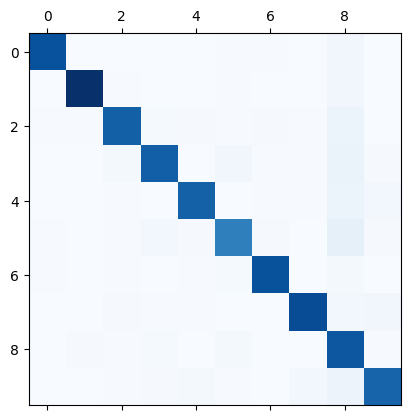

In [48]:
plt.matshow(conf_mx , cmap =v)

图像化混淆矩阵是为了观察错误分布，当对角线值较大时，会影响观察


In [49]:
row_sums = conf_mx.sum(axis = 1 , keepdims = True)
normal_conf_mx = conf_mx / row_sums
#将数量换成比例

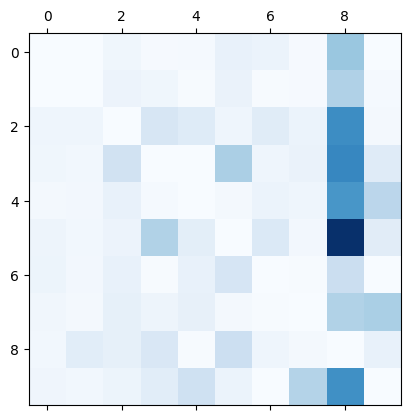

In [50]:
np.fill_diagonal(normal_conf_mx , 0 )
#对角线清零
plt.matshow(normal_conf_mx , cmap =  plt.cm.Blues)